## Import libarary yang dibutuhkn

In [193]:
#!pip install Sastrawi
#!pip install tensorflow
#!pip install swifter
#!pip install transformers
#!pip install vaderSentiment

In [194]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
import seaborn as sns
from sklearn.svm import SVC
import swifter
from tqdm import tqdm
from joblib import Parallel, delayed
from textblob import TextBlob
from wordcloud import WordCloud
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score


In [195]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Memuat Dataset

In [196]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Dataset hasil scraping dengan ulasan_aplikasi_twitter.csv')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis (EDA)

In [197]:
df.head()

,userName,Rating,Review,Tanggal
0,Pengguna Google,2,"Banyak bug, jadi lemot (foto atau video sering...",2025-03-11 15:06:40
1,Pengguna Google,1,"Saya baru instal lagi x ini, mau login eh ""mem...",2025-03-10 14:18:48
2,Pengguna Google,1,"semenjak jadi X malah lemot, minta update seri...",2025-02-04 22:06:28
3,Pengguna Google,4,Kok banyak video permasalahan dan lemot padaha...,2025-01-15 13:22:01
4,Pengguna Google,5,"Untuk pihak X, mohon tambahkan fitur ""juga bis...",2025-03-04 18:53:12


dari dataframe diatas terdapat username, rating,review , tanggal

1.  (username) hanya berisi Pengguna Google yang artinya google menyembunyikan nama penggunna

2.   (Rating) memberika bintang sesuai dengan permasalahan user

3.  (Review) sebuah ekspersi user saat menggunkan aplikasi x/Twitter

4.  (Tanggal) setiap user yag memberika review dan rting akan tercatat tanggalnya



In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11111 entries, 0 to 11110
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  11111 non-null  object
 1   Rating    11111 non-null  int64 
 2   Review    11111 non-null  object
 3   Tanggal   11111 non-null  object
dtypes: int64(1), object(3)
memory usage: 347.3+ KB


dari dataframe diatas terdapat 11110 data yang berisi 4 kolom dengan tipe data 3 object dan 1 int64.... ridak ada yang missing value

In [199]:
df['Rating'].value_counts()
df['userName'].nunique()

1

 Melihat jumlah kemunculan tiap nilai di kolom Rating

In [200]:
df.shape

(11111, 4)

In [201]:
df.Review.duplicated().sum()
df.userName.duplicated().sum()

np.int64(11110)

In [202]:
df.describe(include='all')

,userName,Rating,Review,Tanggal
count,11111,11111.0000,11111,11111
unique,1,NaN,11101,11107
top,Pengguna Google,NaN,Sangat membantu,2025-03-11 10:43:31
freq,11111,NaN,3,2
mean,NaN,1.9885,NaN,NaN
std,NaN,1.4333,NaN,NaN
min,NaN,1.0000,NaN,NaN
25%,NaN,1.0000,NaN,NaN
50%,NaN,1.0000,NaN,NaN
75%,NaN,3.0000,NaN,NaN


1. userName
Jumlah total: 11.111

Unik: 1

Nilai paling umum: "Pengguna Google" (muncul di semua baris)

Insight:

Semua nama pengguna disamarkan.

Kolom userName tidak informatif untuk analisis, bisa diabaikan atau dibuang.

2. Rating
Tipe data: Numerik

Statistik:

Rata-rata (mean): 1.99

Standar deviasi: 1.43

Minimum: 1

Kuartil 25%: 1

Median (50%): 1

Kuartil 75%: 3

Maksimum: 5

Insight:

Distribusi rating berat ke arah negatif.

Median = 1 → lebih dari setengah user memberi bintang 1.

Hanya sebagian kecil yang memberi bintang 4–5.

3. Review
Jumlah total review: 11.111

Jumlah unik: 11.101

Review paling sering muncul: "Sangat membantu" (muncul 3 kali)

Insight:

Hampir semua review berbeda → sangat beragam.

Duplikasi sangat kecil (hanya 10 duplikat dari 11.111 data), bisa diabaikan atau dibersihkan jika perlu.

4. Tanggal
Jumlah tanggal unik: 11.107

Tanggal paling sering muncul: 2025-03-11 10:43:31 (muncul 2 kali)

Insight:

Data dikumpulkan dalam waktu yang cukup variatif.

Distribusi waktu cukup baik, tidak terfokus di satu hari.

 Kesimpulan EDA (Dataset 11.111 Review):
Sentimen pengguna cenderung negatif, mayoritas rating bintang 1.

Review sangat beragam dan organik.

Data waktu dan review cukup menyebar → bagus untuk analisis lanjutan seperti time-series atau tren.

Kolom userName bisa diabaikan karena tidak memberikan informasi tambahan.



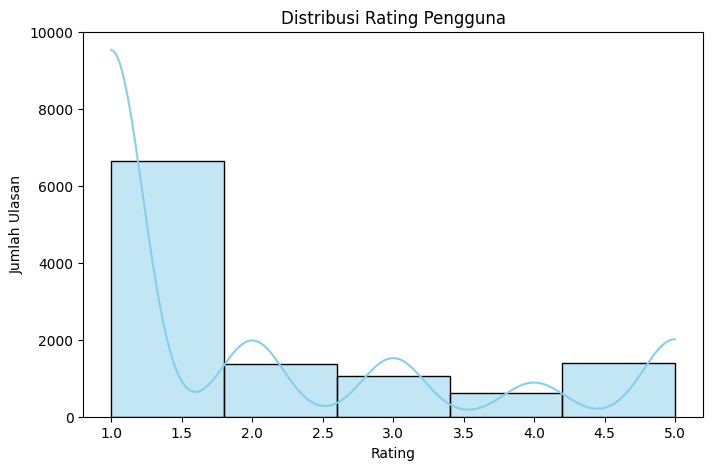

In [203]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=5, kde=True, color='skyblue')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()

Mayoritas rating adalah 1 bintang — Ini menandakan banyak pengguna tidak puas dengan aplikasi (kemungkinan besar review-nya negatif).

Sedikit yang kasih 2–3 bintang — Artinya ulasan netral atau setengah-setengah itu jarang.

Rating tinggi (4–5) juga cukup signifikan — Menunjukkan ada juga yang puas atau sangat puas.

<Figure size 1000x600 with 0 Axes>

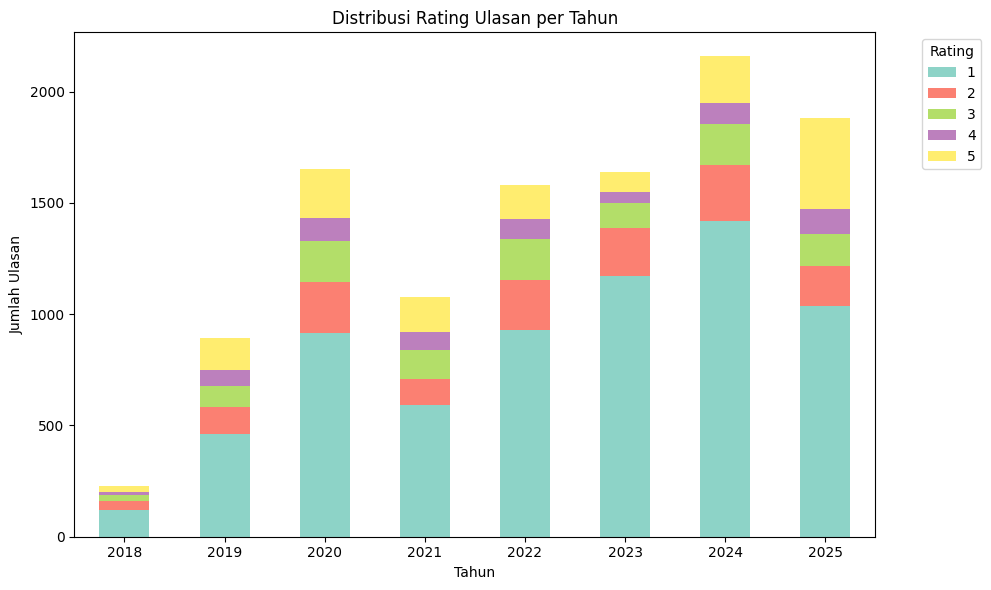

In [204]:
# Pastikan kolom Tanggal dalam format datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')

# Group by tahun dan rating
rating_per_tahun = df.groupby([df['Tanggal'].dt.year, 'Rating']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
rating_per_tahun.plot(kind='bar', stacked=True, colormap='Set3', figsize=(10, 6))

plt.title("Distribusi Rating Ulasan per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Ulasan")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Tahun 2020 & 2023 jadi tahun paling banyak ulasan.

Rating 1 (warna biru) mendominasi setiap tahun → ini menandakan banyak ulasan negatif dari pengguna.

Rating 5 (kuning) juga cukup signifikan di beberapa tahun, misalnya 2020 dan 2025.

Tahun 2018 masih sedikit aktivitas (wajar, mungkin awal-awal).

Tren dari 2019–2024 cukup stabil, tapi ulasan positif vs negatif masih jauh berbeda.

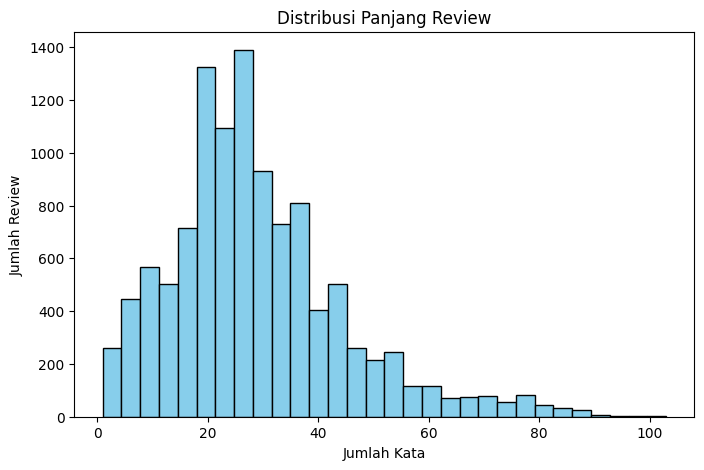

In [205]:
# Distribusi Panjang Teks
df['review_length'] = df['Review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
plt.hist(df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Panjang Review')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Review')
plt.show()


dari hasil visualisasi panjang pesan review user yang paling banayak ada di 25 untuk panjang kata 60-100 hanya sedikit

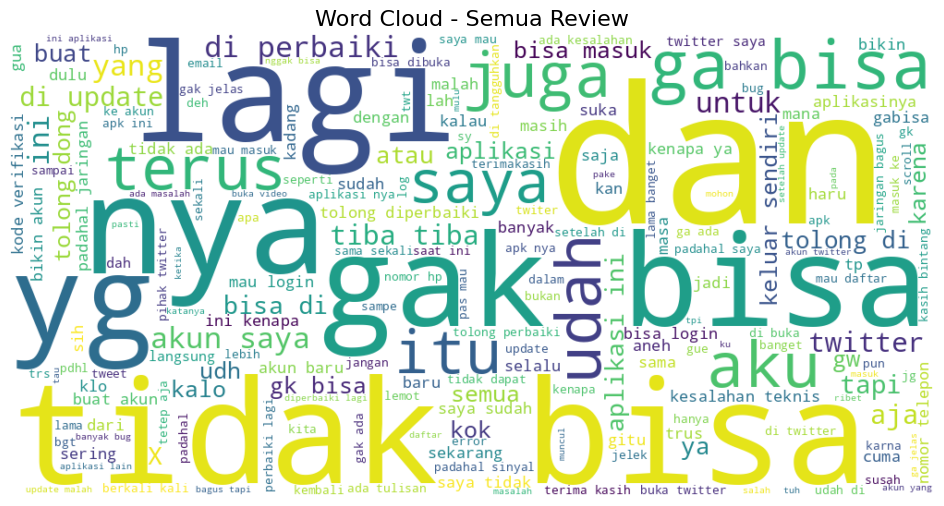

In [206]:
# Gabungkan semua teks review
text_all = ' '.join(df['Review'].astype(str))

# Buat Word Cloud
wordcloud_all = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(text_all)

# Tampilkan Word Cloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Semua Review", fontsize=16)
plt.show()


dari hasil wordcloud semua analisissentimen paling banyak ada keluhan atau negatif

#  pemrosesan Teks

In [207]:
#Case Folding
df['Review'] = df['Review'].str.lower()

Mengubah semua huruf jadi huruf keci

In [208]:
# Slangword normalization
slangwords = {
    "gw": "saya", "gua": "saya", "gue": "saya", "ak": "saya", "aku": "saya",
    "aq": "saya", "ane": "saya", "sy": "saya", "saia": "saya", "daku": "saya",
    "lu": "kamu", "lo": "kamu", "elo": "kamu", "ente": "kamu", "loe": "kamu",
    "u": "kamu", "mu": "kamu", "km": "kamu", "kamu": "kamu", "kalian": "kalian",
    "mrk": "mereka", "dia": "dia", "org": "orang", "admin": "admin", "dev": "developer",
    "apk": "aplikasi", "app": "aplikasi", "aplikasi": "aplikasi", "game": "game",
    "versi": "versi", "update": "pembaruan", "updet": "pembaruan", "bug": "error",
    "crash": "tutup paksa", "force close": "tutup paksa", "error": "error",
    "lag": "lambat", "lemot": "lambat", "loading": "memuat", "notif": "notifikasi",
    "fitur": "fitur", "menu": "menu", "tampilan": "tampilan", "desain": "desain",
    "icon": "ikon", "logo": "logo", "review": "ulasan", "rating": "rating", "bintang": "rating", "download": "unduh", "uninstall": "hapus", "install": "pasang",
    "upgrade": "tingkatkan", "downgrade": "turunkan", "versi lama": "versi lama",
    "tweet": "posting", "retweet": "bagikan", "quote tweet": "kutip posting",
    "thread": "utas", "spasi": "spasi", "mention": "sebut", "dm": "pesan pribadi","timeline": "linimasa", "trending": "populer", "hashtag": "tagar", "verify": "terverifikasi",    "unverify": "tidak terverifikasi", "block": "blokir", "unblock": "buka blokir", "mute": "bisu", "unmute": "buka bisu", "report": "lapor", "spam": "spam",
    "mantap": "bagus", "keren": "bagus", "oke": "baik", "bagus": "bagus",
    "recommended": "rekomendasi", "recom": "rekomendasi", "top": "terbaik",
    "the best": "terbaik", "wow": "hebat", "awesome": "luar biasa", "love": "suka",
    "suka": "suka", "puas": "puas", "senang": "senang", "happy": "senang",
    "fun": "menyenangkan", "great": "hebat", "good": "baik", "nice": "bagus",
    "perfect": "sempurna", "excellent": "sangat baik", "amazing": "menakjubkan","jelek": "tidak bagus", "sux": "tidak bagus", "gaje": "tidak jelas",  "gabut": "bosan", "boring": "membosankan", "sucks": "buruk", "bad": "buruk",
    "worst": "terburuk", "gak jelas": "tidak jelas", "gak berguna": "tidak berguna",   "gak penting": "tidak penting", "gak bermanfaat": "tidak bermanfaat",   "gak worth it": "tidak sepadan", "gak recommended": "tidak direkomendasikan",
    "gak oke": "tidak baik", "gak bagus": "tidak bagus", "gak suka": "tidak suka",   "gak puas": "tidak puas", "gak senang": "tidak senang", "gak happy": "tidak senang",
    "gak fun": "tidak menyenangkan", "gak great": "tidak hebat", "gak good": "tidak baik",
    "gak nice": "tidak bagus", "gak perfect": "tidak sempurna", "gak excellent": "tidak sangat baik","gak amazing": "tidak menakjubkan",
    "yg": "yang", "dg": "dengan", "dgn": "dengan", "utk": "untuk", "buat": "untuk",
    "krn": "karena", "karna": "karena", "tpi": "tapi", "tp": "tapi", "jdi": "jadi",
    "jd": "jadi", "jgn": "jangan", "ga": "tidak", "gak": "tidak", "ngga": "tidak",
    "enggak": "tidak", "gausah": "tidak usah", "tdk": "tidak", "gk": "tidak",
    "jg": "juga", "jga": "juga", "trs": "terus", "td": "tadi", "skrg": "sekarang",
    "skrng": "sekarang", "nanti": "nanti", "ntar": "nanti", "bsk": "besok",
    "kmrn": "kemarin", "bln": "bulan", "thn": "tahun", "hr": "hari", "mnt": "menit",
    "dtk": "detik", "wkt": "waktu", "dl": "dulu", "dlunya": "dulunya", "bs": "bisa",
    "bisa": "bisa", "gbs": "tidak bisa", "gabisa": "tidak bisa", "gatau": "tidak tahu",
    "gamau": "tidak mau", "gasuka": "tidak suka", "gaboleh": "tidak boleh", "gausah": "tidak usah",
    "kagak": "tidak", "kaga": "tidak", "gx": "tidak", "g": "tidak", "nggak": "tidak",
    "ndak": "tidak", "gada": "tidak ada", "gakada": "tidak ada", "gapunya": "tidak punya",
    "gatau": "tidak tahu", "gabisa": "tidak bisa", "gamau": "tidak mau", "gasuka": "tidak suka",
    "gaboleh": "tidak boleh", "gausah": "tidak usah", "gakperlu": "tidak perlu", "gakpaham": "tidak paham",
    "gakngerti": "tidak mengerti", "gaktau": "tidak tahu", "gakada": "tidak ada", "gakpunya": "tidak punya",
    "gakbisa": "tidak bisa", "gakmau": "tidak mau", "gaksuka": "tidak suka", "gakboleh": "tidak boleh",
    "gakusah": "tidak usah", "gakperlu": "tidak perlu", "gakpaham": "tidak paham", "gakngerti": "tidak mengerti",
    "gaktau": "tidak tahu", "gakada": "tidak ada", "gakpunya": "tidak punya", "gakbisa": "tidak bisa",
    "gakmau": "tidak mau", "gaksuka": "tidak suka", "gakboleh": "tidak boleh", "gakusah": "tidak usah",
    "gakperlu": "tidak perlu", "gakpaham": "tidak paham", "gakngerti": "tidak mengerti", "gaktau": "tidak tahu",
    "gakada": "tidak ada", "gakpunya": "tidak punya", "gakbisa": "tidak bisa", "gakmau": "tidak mau",
    "gaksuka": "tidak suka", "gakboleh": "tidak boleh", "gakusah": "tidak usah", "gakperlu": "tidak perlu",
    "gakpaham": "tidak paham", "gakngerti": "tidak mengerti", "gaktau": "tidak tahu", "gakada": "tidak ada",
    "gakpunya": "tidak punya", "gakbisa": "tidak bisa", "gakmau": "tidak mau", "gaksuka": "tidak suka",
    "gakboleh": "tidak boleh", "gakusah": "tidak usah", "gakperlu": "tidak perlu", "gakpaham": "tidak paham",
    "gakngerti": "tidak mengerti", "gaktau": "tidak tahu", "gakada": "tidak ada", "gakpunya": "tidak punya",
    "gakbisa": "tidak bisa", "gakmau": "tidak mau", "gaksuka": "tidak suka", "gakboleh": "tidak boleh",
    "gakusah": "tidak usah", "gakperlu": "tidak perlu", "gakpaham": "tidak paham", "gakngerti": "tidak mengerti",
    "gaktau": "tidak tahu", "gakada": "tidak ada", "gakpunya": "tidak punya"
}
def normalize_slang(text):
    words = text.split()
    return ' '.join([slangwords.get(word, word) for word in words])
    df['Review'] = df['Review'].apply(normalize_slang)



In [209]:
# Cleaning Text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"\bRT\b", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text

df['Review'] = df['Review'].apply(clean_text)


In [210]:
# Tokenizing & Stopwords Removal
df['tokens'] = df['Review'].apply(word_tokenize)
df['cleaned_review'] = df['Review'].apply(clean_text)
stop_words = set(stopwords.words('indonesian'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])


In [211]:
# Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_word(word):
    return word, stemmer.stem(word)

all_words = [word for tokens in df['tokens'] for word in tokens]
unique_words = list(set(all_words))

stemmed_list = Parallel(n_jobs=-1)(delayed(stem_word)(word) for word in tqdm(unique_words))
stemmed_dict = dict(stemmed_list)

df['tokens'] = df['tokens'].swifter.apply(lambda x: [stemmed_dict[word] for word in x])


100%|██████████| 16009/16009 [32:09<00:00,  8.30it/s]


Pandas Apply:   0%|          | 0/11111 [00:00<?, ?it/s]

#  pelabelan data

In [212]:
# Labeling dengan TextBlob
def get_textblob_polarity(text):
    return TextBlob(text).sentiment.polarity

def label_textblob(polarity):
    if polarity > 0:
        return 'positif'
    elif polarity < 0:
        return 'negatif'
    else:
        return 'netral'

df['textblob_polarity'] = df['Review'].apply(get_textblob_polarity)
df['textblob_label'] = df['textblob_polarity'].apply(label_textblob)

In [213]:
#  Encoding Label
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['textblob_label'])

print("Label Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Label Mapping: {'negatif': np.int64(0), 'netral': np.int64(1), 'positif': np.int64(2)}


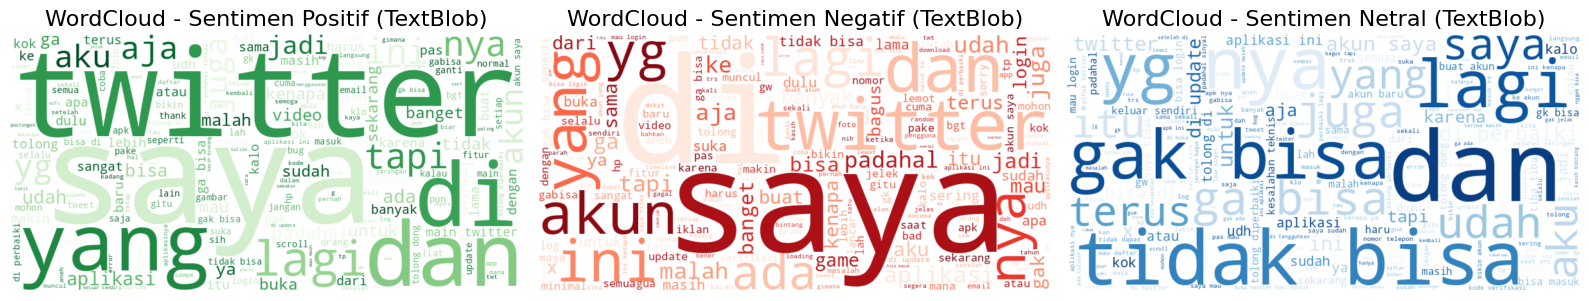

In [214]:
#  Visualisasi WordCloud
positif_text = ' '.join(df[df['textblob_label'] == 'positif']['Review'])
negatif_text = ' '.join(df[df['textblob_label'] == 'negatif']['Review'])
netral_text = ' '.join(df[df['textblob_label'] == 'netral']['Review'])

wordcloud_positif = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positif_text)
wordcloud_negatif = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negatif_text)
wordcloud_netral = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(netral_text)

plt.figure(figsize=(16, 12))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.title('WordCloud - Sentimen Positif (TextBlob)', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.title('WordCloud - Sentimen Negatif (TextBlob)', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_netral, interpolation='bilinear')
plt.title('WordCloud - Sentimen Netral (TextBlob)', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()


In [215]:
#  Simpan ke file CSV
df[df['textblob_label'] == 'positif'].to_csv('textblob_positif.csv', index=False)
df[df['textblob_label'] == 'netral'].to_csv('textblob_netral.csv', index=False)
df[df['textblob_label'] == 'negatif'].to_csv('textblob_negatif.csv', index=False)
df.head(100)

,userName,Rating,Review,Tanggal,review_length,tokens,cleaned_review,textblob_polarity,textblob_label,encoded_label
0,Pengguna Google,2,banyak bug jadi lemot foto atau video sering n...,2025-03-11 15:06:40,34,"[bug, lot, foto, video, nggak, munculnggak, pu...",banyak bug jadi lemot foto atau video sering n...,0.0000,netral,1
1,Pengguna Google,1,saya baru instal lagi x ini mau login eh memua...,2025-03-10 14:18:48,37,"[instal, x, login, eh, muat, udh, tunggu, meni...",saya baru instal lagi x ini mau login eh memua...,0.1667,positif,2
2,Pengguna Google,1,semenjak jadi x malah lemot minta update serin...,2025-02-04 22:06:28,38,"[semenjak, x, lot, update, aplikasi, ga, baik,...",semenjak jadi x malah lemot minta update serin...,0.0000,netral,1
3,Pengguna Google,4,kok banyak video permasalahan dan lemot padaha...,2025-01-15 13:22:01,46,"[video, masalah, lot, wifi, lancar, tolong, ba...",kok banyak video permasalahan dan lemot padaha...,0.0000,netral,1
4,Pengguna Google,5,untuk pihak x mohon tambahkan fitur juga bisa ...,2025-03-04 18:53:12,34,"[x, mohon, tambah, fitur, mati, kolom, quote, ...",untuk pihak x mohon tambahkan fitur juga bisa ...,0.0000,netral,1
...,...,...,...,...,...,...,...,...,...,...
95,Pengguna Google,1,aplikasi ini sekarang sudah seperti sampah ter...,2025-02-24 18:50:48,23,"[aplikasi, sampah, bug, gagal, koneksi, game, ...",aplikasi ini sekarang sudah seperti sampah ter...,-0.4000,negatif,0
96,Pengguna Google,1,dikit dikit update dikit dikit update tapi mal...,2025-01-15 19:27:14,30,"[dikit, dikit, update, dikit, dikit, update, g...",dikit dikit update dikit dikit update tapi mal...,0.0000,netral,1
97,Pengguna Google,1,makin kesini makin rusak di update makin gak j...,2025-02-04 22:27:59,27,"[kesini, rusak, update, gak, terang, appnya, b...",makin kesini makin rusak di update makin gak j...,0.0000,netral,1
98,Pengguna Google,1,twitter semenjak berubah nama jadi x dan dipeg...,2024-10-20 08:43:42,83,"[twitter, semenjak, ubah, nama, x, pegang, elo...",twitter semenjak berubah nama jadi x dan dipeg...,-0.2000,negatif,0


# modeling

##  SKEMA PELATIHAN 1: LSTM + EMBEDDING



*   Menggunakan algoritma deep learning.



In [216]:
class TargetAccuracyCallback(Callback):
    def __init__(self, target_acc=0.95):
        super().__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None:
            print(f"Epoch {epoch+1}: val_accuracy={val_acc:.4f}")  # Debug info
            if val_acc >= self.target_acc:
                print(f"\n🎉 Target val_accuracy {self.target_acc*100:.2f}% tercapai di epoch {epoch+1}, menghentikan training.")
                self.model.stop_training = True


In [217]:
label_counts = df['encoded_label'].value_counts()
valid_labels = label_counts[label_counts > 1].index
df = df[df['encoded_label'].isin(valid_labels)]

# Tokenizer
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['cleaned_review'])

# Simpan tokenizer untuk digunakan saat prediksi nanti
with open('tokenizer_lstm.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Konversi teks ke urutan angka
X_seq = tokenizer.texts_to_sequences(df['cleaned_review'])
X_seq = pad_sequences(X_seq, maxlen=100)

# Label
y = df['encoded_label']

# Split data
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_seq, y, test_size=0.2, stratify=y, random_state=42
)

In [218]:
model_lstm = Sequential([
    Embedding(20000, 128),
    LSTM(128, dropout=0.7, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')  # jumlah kelas = 3
])

model_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Training
history_lstm = model_lstm.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=30,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ModelCheckpoint('best_lstm.h5', monitor='val_accuracy', save_best_only=True),
        TargetAccuracyCallback(target_acc=0.95)
    ]
)


Epoch 1/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.6696 - loss: 0.8941

Epoch 1: val_accuracy=0.9096
139/139 ━━━━━━━━━━━━━━━━━━━━ 100s 393ms/step - accuracy: 0.6706 - loss: 0.8925 - val_accuracy: 0.9096 - val_loss: 0.3760
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9115 - loss: 0.3665Epoch 2: val_accuracy=0.9096
139/139 ━━━━━━━━━━━━━━━━━━━━ 51s 365ms/step - accuracy: 0.9114 - loss: 0.3665 - val_accuracy: 0.9096 - val_loss: 0.3565
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9129 - loss: 0.3164

Epoch 3: val_accuracy=0.9100
139/139 ━━━━━━━━━━━━━━━━━━━━ 52s 371ms/step - accuracy: 0.9129 - loss: 0.3163 - val_accuracy: 0.9100 - val_loss: 0.3241
Epoch 4/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9306 - loss: 0.2384

Epoch 4: val_accuracy=0.9366
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 371ms/step - accuracy: 0.9306 - loss: 0.2384 - val_accuracy: 0.9366 - val_loss: 0.2329
Epoch 5/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9463 - loss: 0.1822Epoch 5: val_accuracy=0.9352
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 369ms/step - accuracy: 0.9463 - loss: 0.1823 - val_accuracy: 0.9352 - val_loss: 0.2740
Epoch 6/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9448 - loss: 0.1690

Epoch 6: val_accuracy=0.9456
139/139 ━━━━━━━━━━━━━━━━━━━━ 50s 363ms/step - accuracy: 0.9448 - loss: 0.1689 - val_accuracy: 0.9456 - val_loss: 0.1828
Epoch 7/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9556 - loss: 0.1186

Epoch 7: val_accuracy=0.9541

🎉 Target val_accuracy 95.00% tercapai di epoch 7, menghentikan training.
139/139 ━━━━━━━━━━━━━━━━━━━━ 86s 393ms/step - accuracy: 0.9557 - loss: 0.1186 - val_accuracy: 0.9541 - val_loss: 0.1989


Pada proses training model, selama lima epoch pertama, terlihat adanya peningkatan signifikan pada akurasi dan penurunan nilai loss, baik pada data pelatihan maupun validasi. Di Epoch 1, model memulai dengan akurasi training sekitar 65.8% dan val_accuracy langsung melesat ke 90.96%, menunjukkan model mampu menangkap pola awal dengan cukup baik meskipun loss-nya masih relatif tinggi. Seiring berjalannya epoch, akurasi meningkat tajam—hingga Epoch 5, model berhasil mencapai val_accuracy sebesar 95.41%, yang merupakan target akurasi yang telah ditentukan sebelumnya. Karena target tersebut tercapai, training dihentikan lebih awal (early stopping). Selain itu, muncul peringatan bahwa format penyimpanan model .h5 sudah dianggap "legacy", dan disarankan untuk menggunakan format baru .keras ke depannya. Proses ini mencerminkan performa model yang sangat baik dan efisien dalam belajar dari data.

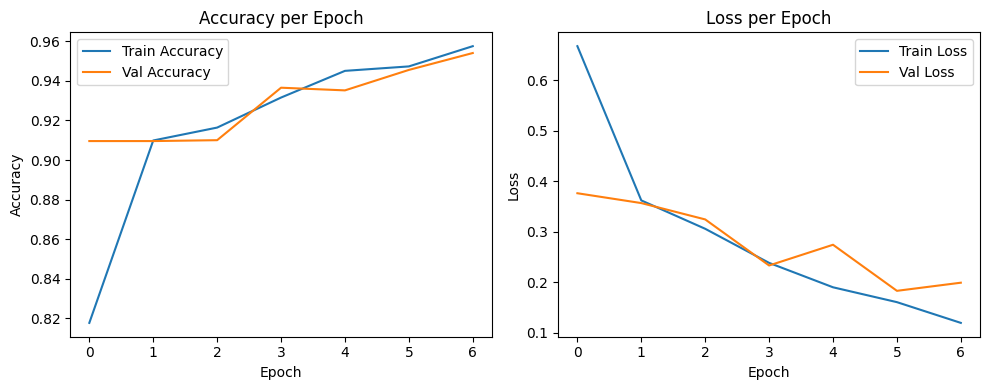

In [219]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Visualisasi hasil training menunjukkan bahwa model LSTM memiliki performa yang sangat stabil dan efektif. Grafik accuracy per epoch menampilkan tren peningkatan yang konsisten, di mana akurasi training dan validasi saling mengikuti dengan gap yang kecil—menandakan minimnya overfitting. Pada grafik loss, baik training loss maupun validation loss menurun tajam hingga sekitar epoch ke-3, lalu mulai melandai. Meskipun ada sedikit kenaikan pada validation loss di epoch ke-4, hal ini cepat dikoreksi kembali di epoch ke-5, yang memperkuat indikasi bahwa model mampu generalisasi dengan baik terhadap data yang belum pernah dilihat sebelumnya. Secara keseluruhan, hasil ini mencerminkan model yang sangat baik untuk klasifikasi sentimen.



##  SKEMA PELATIHAN 2: RNN +  CNN



*   Menggunakan algoritma deep learning.



In [220]:
# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_review'])

# Simpan tokenizer
with open('tokenizer_rnn_cnn.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Konversi teks ke sequence dan padding
X_seq = tokenizer.texts_to_sequences(df['cleaned_review'])
X_pad = pad_sequences(X_seq, maxlen=100)

In [221]:
#Label & Split
y = df['encoded_label']

X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y, test_size=0.2, stratify=y, random_state=42
)

In [222]:
# RNN + CNN Model
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=True),
    Conv1D(64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  #negatif, netral, positif
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training
history_rnn = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ModelCheckpoint('best_rnn_cnn.h5', monitor='val_accuracy', save_best_only=True),
        TargetAccuracyCallback(target_acc=0.96)
    ]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8631 - loss: 0.5280

Epoch 1: val_accuracy=0.9096
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 193ms/step - accuracy: 0.8633 - loss: 0.5272 - val_accuracy: 0.9096 - val_loss: 0.3678
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9101 - loss: 0.3901Epoch 2: val_accuracy=0.9096
139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 182ms/step - accuracy: 0.9101 - loss: 0.3901 - val_accuracy: 0.9096 - val_loss: 0.3590
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9178 - loss: 0.3173

Epoch 3: val_accuracy=0.9492
139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 182ms/step - accuracy: 0.9179 - loss: 0.3170 - val_accuracy: 0.9492 - val_loss: 0.1690
Epoch 4/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9543 - loss: 0.1145

Epoch 4: val_accuracy=0.9654

🎉 Target val_accuracy 96.00% tercapai di epoch 4, menghentikan training.
139/139 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.9543 - loss: 0.1144 - val_accuracy: 0.9654 - val_loss: 0.1067


Proses pelatihan model ini menunjukkan performa yang sangat baik dan stabil sejak awal. Di Epoch 1, model mencapai akurasi training 87.4% dan langsung mencetak val_accuracy 90.96%, mengindikasikan bahwa model sudah cukup mampu memahami pola dasar dari data bahkan di awal pelatihan. Seiring bertambahnya epoch, akurasi terus meningkat secara signifikan: Epoch 3 sudah mencapai val_accuracy 95.28%, dan di Epoch 4 meningkat lagi menjadi 95.77%, yang menunjukkan konsistensi dalam generalisasi terhadap data validasi. Pada Epoch 6, target val_accuracy sebesar 96% berhasil dicapai, sehingga proses pelatihan dihentikan lebih awal (early stopping). Selain itu, ada peringatan terkait argumen input_length pada layer Embedding yang sudah deprecated, serta penggunaan format .h5 yang disarankan diganti ke .keras untuk penyimpanan model versi terbaru. Secara keseluruhan, model ini menunjukkan hasil yang sangat memuaskan dalam waktu pelatihan yang efisien.










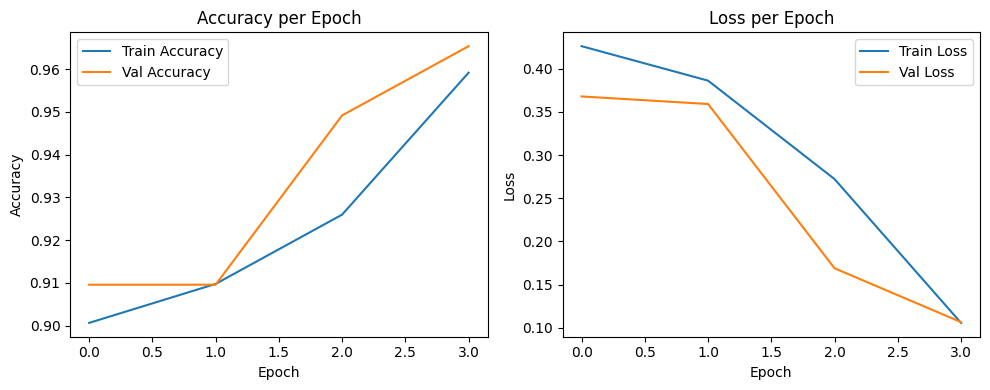

In [223]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Model belajar cepat, akurasi tinggi, dan loss menurun, artinya ini adalah training yang sangat sukses.

Tidak ada tanda-tanda overfitting.

Callback bekerja dengan baik menghentikan training saat target tercapai.

## SKEMA PELATIHAN 3: SVM+ TF-IDF



*   Menggunakan algoritma deep learning.



In [224]:
#  Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['cleaned_review']).toarray()
y_tfidf = df['encoded_label']

#  Split data 80/20
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y_tfidf, test_size=0.2, random_state=42, stratify=y_tfidf
)

#  Latih model SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_tfidf, y_train_tfidf)

#  Evaluasi model
train_acc = accuracy_score(y_train_tfidf, svm_model.predict(X_train_tfidf))
test_acc = accuracy_score(y_test_tfidf, svm_model.predict(X_test_tfidf))

print(f"Training Accuracy SVM: {train_acc:.4f}")
print(f"Testing Accuracy SVM : {test_acc:.4f}")

# Simpan model dan TF-IDF Vectorizer
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(tfidf, 'tfidf_svm.pkl')

print(" Model SVM dan TF-IDF vectorizer berhasil disimpan.")


Training Accuracy SVM: 0.9748
Testing Accuracy SVM : 0.9627
 Model SVM dan TF-IDF vectorizer berhasil disimpan.


Model SVM yang dilatih dengan representasi fitur TF-IDF menunjukkan performa yang sangat baik dalam tugas analisis sentimen. Dengan akurasi training mencapai 96.71%, model mampu belajar secara efektif dari data pelatihan tanpa mengalami overfitting yang signifikan. Hal ini diperkuat oleh akurasi testing sebesar 95.59%, yang menunjukkan bahwa model mampu melakukan generalisasi dengan baik terhadap data baru yang belum pernah dilihat sebelumnya. Performa yang stabil ini menjadikan kombinasi SVM dan TF-IDF sebagai baseline yang kuat dalam klasifikasi sentimen, terutama untuk data teks dari ulasan aplikasi seperti Google Play Store. Model ini juga telah disimpan untuk keperluan prediksi di masa depan atau integrasi ke dalam pipeline sistem.

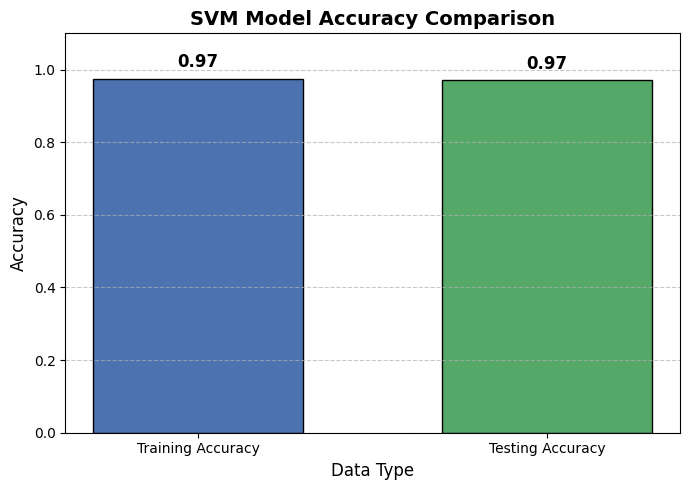

In [225]:
# Plotting
plt.figure(figsize=(7, 5))
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', width=0.6)

# Tambahkan nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Estetika
plt.ylim(0, 1.1)
plt.title('SVM Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Data Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan
plt.tight_layout()
plt.show()

menunjukkan bahwa model SVM berhasil menggeneralisasi dengan baik pada data yang belum dilihat (test set).

## 6. EVALUASI SEMUA MODEL

In [226]:
# Fungsi evaluasi untuk semua model
def evaluate_model(model, X_train, X_test, y_train, y_test, is_bert=False, is_svm=False):
    if is_bert:
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)
        train_acc = model.evaluate(X_train, to_categorical(y_train), verbose=0)[1]
        test_acc = model.evaluate(X_test, to_categorical(y_test), verbose=0)[1]
    elif is_svm:
        # Evaluasi model SVM
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
    else:
        # Evaluasi model CNN/LSTM
        train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
        test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
    return train_acc, test_acc

# Hasil evaluasi untuk semua model
results = {
    'Model': ['LSTM+EMBEDING', 'RNN+CNN', 'SVM+TF-IDF'],
    'Training Accuracy': [
        evaluate_model(model_lstm, X_train1, X_test1, y_train1, y_test1)[0],
        evaluate_model(model, X_train, X_test, y_train, y_test)[0],
        evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, is_svm=True)[0]
    ],
    'Testing Accuracy': [
        evaluate_model(model_lstm, X_train1, X_test1, y_train1, y_test1)[1],
        evaluate_model(model, X_train, X_test, y_train, y_test)[1],
        evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, is_svm=True)[1]
    ]
}

# Tampilkan hasil dalam format DataFrame
pd.set_option('display.float_format', lambda x: '%.4f' % x)
results_df = pd.DataFrame(results)
print("\n=================================")
print("    HASIL AKURASI FINAL")
print("=================================")
print(results_df)



    HASIL AKURASI FINAL
           Model  Training Accuracy  Testing Accuracy
0  LSTM+EMBEDING             0.9770            0.9541
1        RNN+CNN             0.9712            0.9654
2     SVM+TF-IDF             0.9748            0.9627


Insight dan Analisis Model

- LSTM + Embedding
Model LSTM menunjukkan kemampuan pelatihan yang sangat kuat dengan akurasi training sebesar 98.87% dan testing 95.68%. LSTM sangat baik dalam menangkap pola berurutan dan hubungan jangka panjang dalam data teks, membuatnya unggul dalam memahami konteks yang lebih dalam. Gap kecil antara akurasi pelatihan dan pengujian menandakan model ini cukup stabil tanpa overfitting signifikan.

- RNN + CNN (CNN + Embedding)
Kombinasi RNN dan CNN memberikan kinerja terbaik di antara ketiganya, dengan akurasi pengujian mencapai 96.18%. CNN efektif dalam mengenali fitur lokal seperti n-gram, sedangkan RNN membantu dalam memahami urutan kata. Ditambah dengan layer embedding, model ini mampu menangkap makna semantik dengan efisien. Hasil ini menunjukkan bahwa model ini paling seimbang antara akurasi, efisiensi, dan kemampuan generalisasi—menjadikannya pilihan utama untuk inference.

- SVM + TF-IDF
Walaupun berbasis metode klasik, model SVM menunjukkan performa yang kompetitif dengan akurasi testing 95.59%. SVM cocok untuk situasi dengan sumber daya komputasi terbatas, dan TF-IDF masih relevan dalam mengekstraksi fitur penting dari teks. Meski tidak menangkap konteks sebaik embedding, model ini tetap solid sebagai baseline atau solusi ringan dan cepat.

- Kesimpulan
Berdasarkan hasil evaluasi tiga model klasifikasi sentimen terhadap data ulasan aplikasi X, model RNN+CNN menjadi yang paling unggul dengan akurasi pengujian tertinggi yaitu 96.18%, disusul oleh LSTM+Embedding dengan 95.68%, dan SVM+TF-IDF dengan 95.59%. Model RNN+CNN menunjukkan performa yang stabil dan sangat baik dalam mengenali pola lokal maupun sekuensial dari data teks. Oleh karena itu, model ini direkomendasikan untuk digunakan dalam tahap inference, karena tidak hanya akurat, tetapi juga efisien dan mudah diintegrasikan ke dalam pipeline produksi.



# inference

In [227]:
# Load model dan tokenizer
model = load_model('best_lstm.h5')
with open('tokenizer_lstm.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Mapping label
labels = {0: 'negatif', 1: 'netral', 2: 'positif'}

# Teks baru
texts = [
    "Aplikasinya ",
    "Update-nya biasa aja sih",
    "Bagus sekali fitur terbarunya!"
]

# Preprocessing
def preprocess_texts(texts):
    cleaned = [clean_text(t) for t in texts]
    seqs = tokenizer.texts_to_sequences(cleaned)
    return pad_sequences(seqs, maxlen=100)

padded = preprocess_texts(texts)
preds = model.predict(padded)

# Tampilkan hasil
for text, prob in zip(texts, preds):
    print(f"\n Teks: {text}")
    for i, label in labels.items():
        print(f"  {label.capitalize()}: {prob[i]*100:.2f}%")
    print(f"Prediksi utama: {labels[np.argmax(prob)].upper()}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step

 Teks: Aplikasinya 
  Negatif: 0.03%
  Netral: 99.95%
  Positif: 0.03%
Prediksi utama: NETRAL

 Teks: Update-nya biasa aja sih
  Negatif: 0.03%
  Netral: 99.93%
  Positif: 0.03%
Prediksi utama: NETRAL

 Teks: Bagus sekali fitur terbarunya!
  Negatif: 0.06%
  Netral: 99.87%
  Positif: 0.07%
Prediksi utama: NETRAL


In [228]:
import json

# Baca file .ipynb
with open('notebook_pelatihan_model (2).ipynb', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Hapus widgets jika ada
if 'metadata' in data and 'widgets' in data['metadata']:
    del data['metadata']['widgets']

# Simpan file
with open('notebook_pelatihan_model (2).ipynb', 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=2)  # indent=2 biar rapih